In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import numpy as np
from pathlib import Path

#IMAGE_PATH = "data/az104m5yyrrjdcq8rfqk.jpg"
#INPUT_POINT = (321, 230)
IMAGE_PATH = "data/apple_5x4.jpg"
INPUT_POINT = (960, 810)

ENC_MODEL_PATH = "models/image_encoder_vit_b.onnx"
SAM_MODEL_PATH = "models/sam_vit_b_01ec64.onnx"

MEAN_PIX_VALUES = np.array([123.675, 116.28, 103.53])
STD_PIX_VALUES = np.array([[58.395, 57.12, 57.375]])

SIZE_FOR_INFERENCE = (1024, 1024)


# Load the image

(1620, 1920, 3)


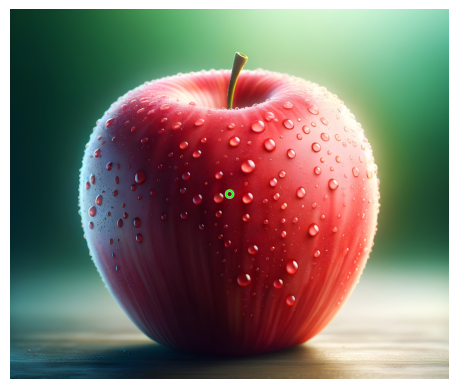

In [28]:
import cv2
from scripts.image import show_image_from_ndarray

image = cv2.imread(IMAGE_PATH)
orig_image_width, orig_image_height = image.shape[1], image.shape[0]
print(image.shape)

# Draw circle on input point

image_to_darw = cv2.circle(image, INPUT_POINT, 15, (255, 255, 255), 10)
image_to_darw = cv2.circle(image, INPUT_POINT, 15, (0, 255, 0), 5)

show_image_from_ndarray(image_to_darw)

In [29]:
import numpy as np
from typing import Tuple


def add_dummy_dim(image: np.ndarray) -> np.ndarray:
    return image[np.newaxis, :, :, :]


def as_normalized_float_tensor(image, pad_h, mean_pix_norm, std_pix_norm):
    image_f = image.copy().astype(np.float32)
    image_f -= np.array(mean_pix_norm)
    image_f /= np.array(std_pix_norm)
    image_tensor = add_dummy_dim(image_f).transpose((0, 3, 1, 2))
    image_tensor[0, :, 0:pad_h, :] = 0
    image_tensor[0, :, -pad_h:, :] = 0
    return image_tensor


def resize_and_pad(
    target_image: np.ndarray, image_size_inference: Tuple[int, int], pad_value: int = 0
):
    _, image_width_raw, _ = target_image.shape
    resize_rate = float(image_size_inference[0]) / image_width_raw
    target_image_resized = cv2.resize(
        target_image, None, fx=resize_rate, fy=resize_rate
    )
    image_height_resized, _, _ = target_image_resized.shape

    pad_h = (image_size_inference[1] - image_height_resized) // 2
    if pad_h > 0:
        target_image_processed = cv2.copyMakeBorder(
            target_image_resized,
            pad_h,
            pad_h,
            0,
            0,
            cv2.BORDER_CONSTANT,
            (pad_value, pad_value, pad_value),
        )
    else:
        target_image_processed = target_image_resized
    target_image_processed = cv2.resize(target_image_processed, image_size_inference)
    return target_image_processed, pad_h, resize_rate

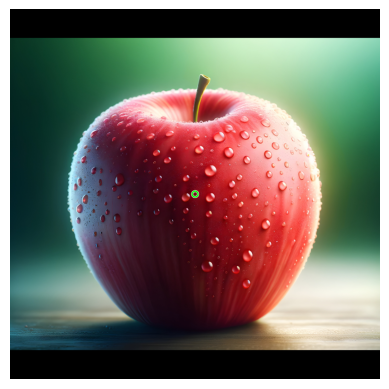

In [30]:
image_processed, pad_h, resize_rate = resize_and_pad(image, SIZE_FOR_INFERENCE)
resized_image_width, resized_image_height = int(orig_image_width * resize_rate), int(
    orig_image_height * resize_rate
)
show_image_from_ndarray(image_processed)

# Encoder

In [31]:
import onnxruntime as ort

encoder = ort.InferenceSession(
    ENC_MODEL_PATH, providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


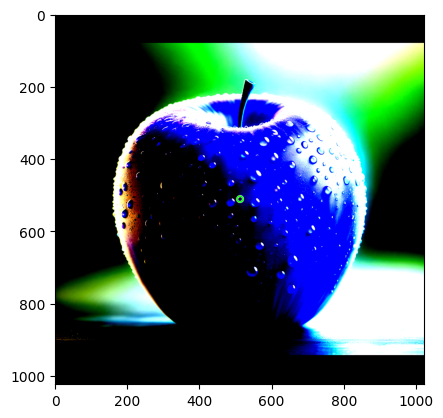

In [32]:
import matplotlib.pyplot as plt

image_tensor = as_normalized_float_tensor(image_processed, pad_h, MEAN_PIX_VALUES, STD_PIX_VALUES)

plt.imshow(image_tensor[0].transpose((1, 2, 0)))

In [33]:
outputs = encoder.run(
    None, {"images": image_tensor}
)
embeddings = outputs[0]
embeddings.shape

(1, 256, 64, 64)

# Decoder

In [34]:
from copy import deepcopy


def generate_coords_and_labels_from_point(input_point_x, input_point_y, resize_rate_from_orig):
    input_point = np.array([[input_point_x, input_point_y]])
    input_label = np.array([1])

    onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[
        None, :, :
    ]
    onnx_label = np.concatenate([input_label, np.array([-1])])[None, :].astype(
        np.float32
    )

    coords = deepcopy(onnx_coord).astype(float)
    coords[..., 0] = coords[..., 0] * resize_rate_from_orig
    coords[..., 1] = coords[..., 1] * resize_rate_from_orig

    onnx_coord = coords.astype("float32")
    return onnx_coord, onnx_label

In [35]:
print(resized_image_width, orig_image_width)
print(resized_image_height, orig_image_height)

1024 1920
864 1620


In [36]:
decoder = ort.InferenceSession(
    SAM_MODEL_PATH, providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
)

In [37]:
onnx_coord, onnx_label = generate_coords_and_labels_from_point(
    INPUT_POINT[0], INPUT_POINT[1], resize_rate
)

onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)
outputs = decoder.run(
    None,
    {
        "image_embeddings": embeddings,
        "point_coords": onnx_coord,
        "point_labels": onnx_label,
        "mask_input": onnx_mask_input,
        "has_mask_input": onnx_has_mask_input,
        "orig_im_size": np.array(
            [resized_image_width, resized_image_width], dtype=np.float32
        ),
    },
)
masks = outputs[0]
masks.shape

(1, 1, 1024, 1024)

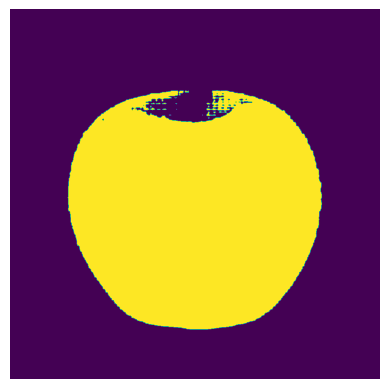

In [38]:
mask = masks[0][0]
mask = (mask > 0).astype('uint8')*255

show_image_from_ndarray(mask)

In [39]:
mask.shape

(1024, 1024)

# Map

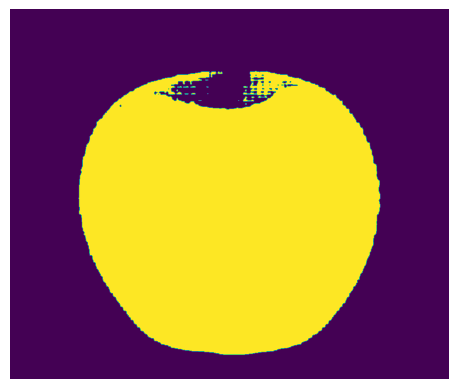

In [40]:
mask_cropped = mask[pad_h:-pad_h]
mask_rawsize = cv2.resize(mask_cropped, (orig_image_width, orig_image_height), interpolation=cv2.INTER_NEAREST)

show_image_from_ndarray(mask_rawsize)

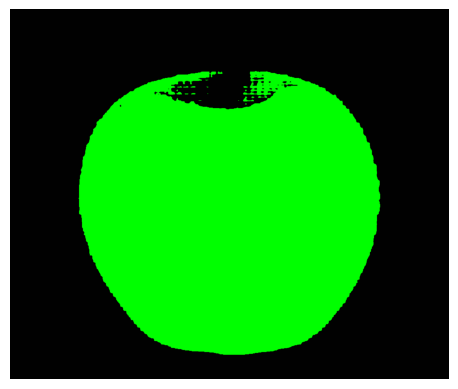

In [41]:
import numpy as np

mask_rgb = np.ones((image.shape[0], image.shape[1], 3), dtype=np.uint8) * 1
where_nonzero = np.where(mask_rawsize > 0)
mask_rgb[where_nonzero[0], where_nonzero[1], :] = np.array([0, 255, 0])

show_image_from_ndarray(mask_rgb)

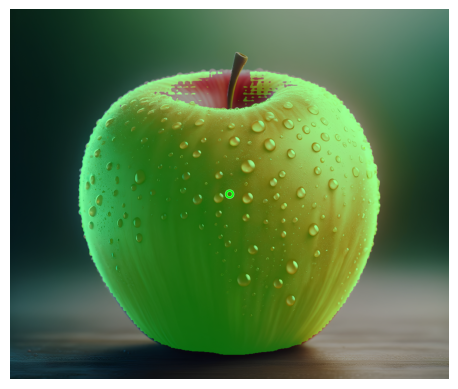

In [42]:
result = cv2.addWeighted(image, 0.6, mask_rgb, 0.4, 2.2)

show_image_from_ndarray(result)